# Module 1 - Step 2: Exploratory Data Analysis & Feature Engineering

#### Bank Marketing Dataset

**Goal:** Predict if client subscribes to term deposit (yes/no)
Size: 41,188 records, 20 features | Balance: 11% yes, 89% no
Features

*Source: Portuguese bank direct marketing campaigns (phone calls), May 2008 - Nov 2010*

In [21]:
# Imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import cml.data_v1 as cmldata

sys.path.append(os.path.dirname(os.getcwd()))
from module1.utils import engineer_customer_engagement_score


In [22]:
from shared_utils import (
    DATALAKE_CONFIG,
    get_spark_session
)

database_name = DATALAKE_CONFIG["database_name"] 
table_name = DATALAKE_CONFIG["table_name"]
username= os.environ["PROJECT_OWNER"]

In [11]:
# Load from data lake
USERNAME = os.environ.get("PROJECT_OWNER", "default_user")
CONNECTION_NAME = os.environ.get("CONNECTION_NAME", "go01-aw-dl")

conn = cmldata.get_connection(CONNECTION_NAME)
spark = conn.get_spark_session()

full_db = f"{database_name}_{username}".upper()
full_table = f"{table_name}_{username}".upper()
full_path = f"{full_db}.{full_table}"

print(f"Loading: {full_path}")
spark_df = spark.table(full_path)
df = spark_df.toPandas()

print(f"Dataset shape: {df.shape}")
df.head()

Spark Application Id:spark-4be3f3becba04bff8d1700021073df5b


In [16]:
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [17]:
# Basic info
print(df.shape)

(41188, 21)


In [19]:
print(df['y'].value_counts())

y
no     36548
yes     4640
Name: count, dtype: int64


In [15]:
#df.sample(1500, random_state=42).to_csv('sample.csv', index=False)

### EDA

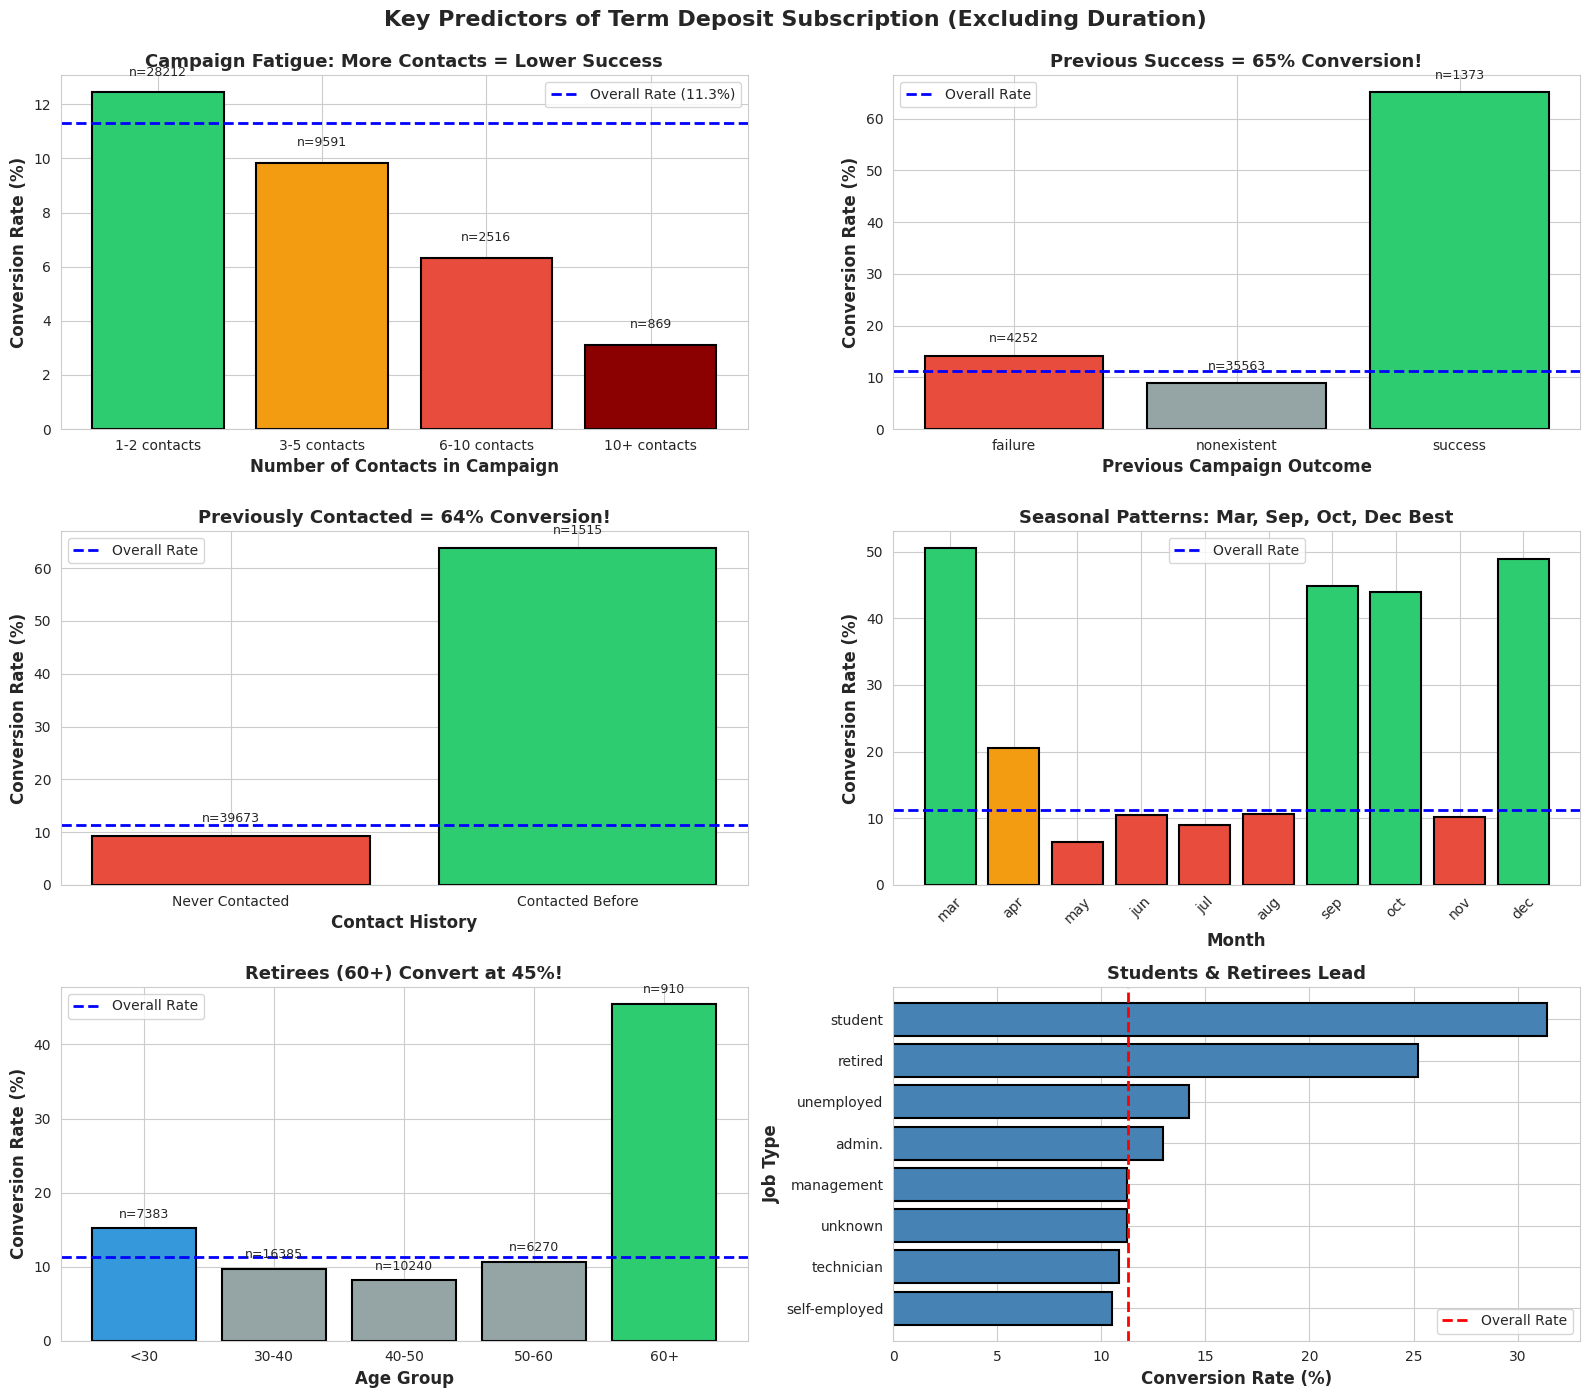


KEY FINDINGS SUMMARY
Overall Conversion Rate: 11.3%

TOP PREDICTORS:
1. Previous Success: 65% (5.8x baseline)
2. Contacted Before: 64% (5.7x baseline)
3. Campaign 1-2: 12% vs 6+: 2%
4. Age 60+: 45% (4.0x baseline)
5. March campaigns: 51% (4.5x baseline)


In [26]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 12)

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Key Predictors of Term Deposit Subscription (Excluding Duration)', 
             fontsize=16, fontweight='bold', y=0.995)

# ============================================
# 1. CAMPAIGN FATIGUE
# ============================================
ax1 = axes[0, 0]

# Group campaigns for cleaner visualization
df['campaign_group'] = pd.cut(df['campaign'], 
                              bins=[0, 2, 5, 10, 100], 
                              labels=['1-2 contacts', '3-5 contacts', '6-10 contacts', '10+ contacts'])

campaign_data = df.groupby('campaign_group', observed=True).agg({
    'y': [lambda x: (x == 'yes').mean() * 100, 'count']
}).reset_index()
campaign_data.columns = ['campaign_group', 'conversion_rate', 'count']

bars = ax1.bar(campaign_data['campaign_group'], campaign_data['conversion_rate'], 
               color=['#2ecc71', '#f39c12', '#e74c3c', '#8b0000'], edgecolor='black', linewidth=1.5)
ax1.axhline(y=11.3, color='blue', linestyle='--', linewidth=2, label='Overall Rate (11.3%)')
ax1.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Number of Contacts in Campaign', fontsize=12, fontweight='bold')
ax1.set_title('Campaign Fatigue: More Contacts = Lower Success', fontsize=13, fontweight='bold')
ax1.legend()

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, campaign_data['count'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'n={int(count)}', ha='center', va='bottom', fontsize=9)

# ============================================
# 2. PREVIOUS CAMPAIGN OUTCOME
# ============================================
ax2 = axes[0, 1]

poutcome_data = df.groupby('poutcome').agg({
    'y': [lambda x: (x == 'yes').mean() * 100, 'count']
}).reset_index()
poutcome_data.columns = ['poutcome', 'conversion_rate', 'count']

colors = {'success': '#2ecc71', 'failure': '#e74c3c', 'nonexistent': '#95a5a6'}
bar_colors = [colors.get(x, '#95a5a6') for x in poutcome_data['poutcome']]

bars = ax2.bar(poutcome_data['poutcome'], poutcome_data['conversion_rate'], 
               color=bar_colors, edgecolor='black', linewidth=1.5)
ax2.axhline(y=11.3, color='blue', linestyle='--', linewidth=2, label='Overall Rate')
ax2.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Previous Campaign Outcome', fontsize=12, fontweight='bold')
ax2.set_title('Previous Success = 65% Conversion!', fontsize=13, fontweight='bold')
ax2.legend()

for i, (bar, count) in enumerate(zip(bars, poutcome_data['count'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'n={int(count)}', ha='center', va='bottom', fontsize=9)

# ============================================
# 3. CONTACT RECENCY (pdays < 999)
# ============================================
ax3 = axes[1, 0]

df['contacted_before'] = df['pdays'] < 999
recency_data = df.groupby('contacted_before').agg({
    'y': [lambda x: (x == 'yes').mean() * 100, 'count']
}).reset_index()
recency_data.columns = ['contacted_before', 'conversion_rate', 'count']
recency_data['label'] = recency_data['contacted_before'].map({False: 'Never Contacted', True: 'Contacted Before'})

bars = ax3.bar(recency_data['label'], recency_data['conversion_rate'], 
               color=['#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.5)
ax3.axhline(y=11.3, color='blue', linestyle='--', linewidth=2, label='Overall Rate')
ax3.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Contact History', fontsize=12, fontweight='bold')
ax3.set_title('Previously Contacted = 64% Conversion!', fontsize=13, fontweight='bold')
ax3.legend()

for i, (bar, count) in enumerate(zip(bars, recency_data['count'])):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'n={int(count)}', ha='center', va='bottom', fontsize=9)

# ============================================
# 4. MONTH SEASONALITY
# ============================================
ax4 = axes[1, 1]

month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_data = df.groupby('month').agg({
    'y': [lambda x: (x == 'yes').mean() * 100, 'count']
}).reset_index()
month_data.columns = ['month', 'conversion_rate', 'count']
month_data['month'] = pd.Categorical(month_data['month'], categories=month_order, ordered=True)
month_data = month_data.sort_values('month')

# Color by performance
colors_month = ['#2ecc71' if x > 30 else '#f39c12' if x > 15 else '#e74c3c' 
                for x in month_data['conversion_rate']]

bars = ax4.bar(month_data['month'], month_data['conversion_rate'], 
               color=colors_month, edgecolor='black', linewidth=1.5)
ax4.axhline(y=11.3, color='blue', linestyle='--', linewidth=2, label='Overall Rate')
ax4.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Month', fontsize=12, fontweight='bold')
ax4.set_title('Seasonal Patterns: Mar, Sep, Oct, Dec Best', fontsize=13, fontweight='bold')
ax4.legend()
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

# ============================================
# 5. AGE GROUPS
# ============================================
ax5 = axes[2, 0]

df['age_group'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 100], 
                         labels=['<30', '30-40', '40-50', '50-60', '60+'])
age_data = df.groupby('age_group', observed=True).agg({
    'y': [lambda x: (x == 'yes').mean() * 100, 'count']
}).reset_index()
age_data.columns = ['age_group', 'conversion_rate', 'count']

# Color by age
colors_age = ['#3498db', '#95a5a6', '#95a5a6', '#95a5a6', '#2ecc71']

bars = ax5.bar(age_data['age_group'], age_data['conversion_rate'], 
               color=colors_age, edgecolor='black', linewidth=1.5)
ax5.axhline(y=11.3, color='blue', linestyle='--', linewidth=2, label='Overall Rate')
ax5.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax5.set_xlabel('Age Group', fontsize=12, fontweight='bold')
ax5.set_title('Retirees (60+) Convert at 45%!', fontsize=13, fontweight='bold')
ax5.legend()

for i, (bar, count) in enumerate(zip(bars, age_data['count'])):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'n={int(count)}', ha='center', va='bottom', fontsize=9)

# ============================================
# 6. JOB TYPE (Top performing)
# ============================================
ax6 = axes[2, 1]

job_data = df.groupby('job').agg({
    'y': [lambda x: (x == 'yes').mean() * 100, 'count']
}).reset_index()
job_data.columns = ['job', 'conversion_rate', 'count']
job_data = job_data.sort_values('conversion_rate', ascending=False).head(8)

bars = ax6.barh(job_data['job'], job_data['conversion_rate'], 
                color='steelblue', edgecolor='black', linewidth=1.5)
ax6.axvline(x=11.3, color='red', linestyle='--', linewidth=2, label='Overall Rate')
ax6.set_xlabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Job Type', fontsize=12, fontweight='bold')
ax6.set_title('Students & Retirees Lead', fontsize=13, fontweight='bold')
ax6.legend()
ax6.invert_yaxis()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("KEY FINDINGS SUMMARY")
print("="*60)
print(f"Overall Conversion Rate: 11.3%")
print(f"\nTOP PREDICTORS:")
print(f"1. Previous Success: 65% (5.8x baseline)")
print(f"2. Contacted Before: 64% (5.7x baseline)")
print(f"3. Campaign 1-2: 12% vs 6+: 2%")
print(f"4. Age 60+: 45% (4.0x baseline)")
print(f"5. March campaigns: 51% (4.5x baseline)")

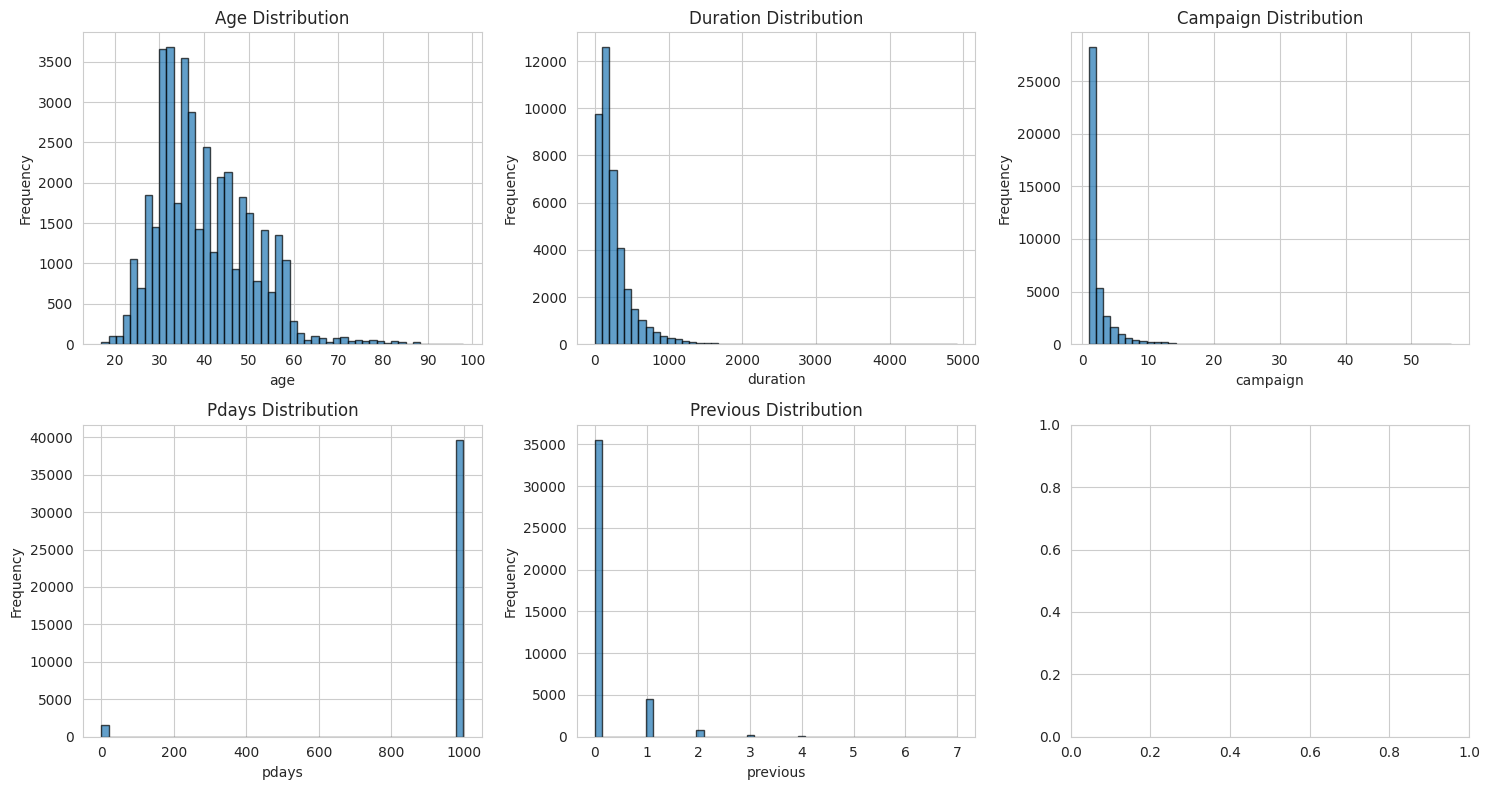

In [8]:

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

# 1. Quick distribution overview - all numeric features
numeric_cols = ['age', 'duration', 'campaign', 'pdays', 'previous']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col.capitalize()} Distribution')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

✓ Imports successful


## 1. Load Data

## 2. Basic Understanding

In [ ]:
print("Data Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Distribution:")
print(df['y'].value_counts())

## 3. Numeric Features

In [ ]:
numeric_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col.capitalize()}')
    axes[idx].set_xlabel(col)

plt.tight_layout()
plt.show()

## 4. Feature Engineering: Engagement Score

In [ ]:
# Create engagement score
df_engineered = engineer_customer_engagement_score(df)

print("✓ Engagement score created!")
print(f"\nStatistics:")
print(df_engineered['engagement_score'].describe())

# Show examples
sample_cols = ['campaign', 'pdays', 'previous', 'poutcome', 'engagement_score', 'y']
print("\nSample customers:")
print(df_engineered[sample_cols].head(10))

## 5. Validate New Feature

In [ ]:
# Compare engagement score by target
yes_scores = df_engineered[df_engineered['y'] == 'yes']['engagement_score']
no_scores = df_engineered[df_engineered['y'] == 'no']['engagement_score']

t_stat, p_value = stats.ttest_ind(yes_scores, no_scores)

print(f"Mean engagement (subscribed): {yes_scores.mean():.4f}")
print(f"Mean engagement (not subscribed): {no_scores.mean():.4f}")
print(f"\nT-test p-value: {p_value:.2e}")

if p_value < 0.001:
    print("\n✓ Highly significant! This feature should help the model.")

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df_engineered.boxplot(column='engagement_score', by='y', ax=ax)
ax.set_title('Engagement Score by Subscription')
plt.suptitle('')
plt.show()

## 6. Save Engineered Dataset

In [ ]:
output_path = 'data/bank_marketing_engineered.csv'
os.makedirs('data', exist_ok=True)
df_engineered.to_csv(output_path, index=False)

print(f"✓ Saved to: {output_path}")
print(f"  Shape: {df_engineered.shape}")
print("\nNext: Run 03_train_with_mlflow.py")